## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

In [3]:
variable = '__xarray_dataarray_variable__'

### 1.1 ERA5

In [4]:
# era5
ivt_era5_urban = xr.open_dataset(r'data/ivt_era5_postprocessed_urban.nc')
ivt_era5_nourban = xr.open_dataset(r'data/ivt_era5_postprocessed_nourban.nc')

### 1.2 GFS

In [5]:
# gfs
ivt_gfs_urban = xr.open_dataset(r'data/ivt_gfs_postprocessed_urban.nc')
ivt_gfs_nourban = xr.open_dataset(r'data/ivt_gfs_postprocessed_nourban.nc')

## 2. Vectorize Tiff Data

In [6]:
proj_dt = xr.open_dataset(r'data/era5_LIN_nourban_ACLHF_wrfout_d03_2017-07-17.nc')
proj_dt = proj_dt.rio.write_crs(proj_dt['ACLHF'].attrs['pyproj_srs'])

In [7]:
gg = rioxarray.open_rasterio('data/lu_index/urban_luse_border_raster.tiff').squeeze('band', drop=True)

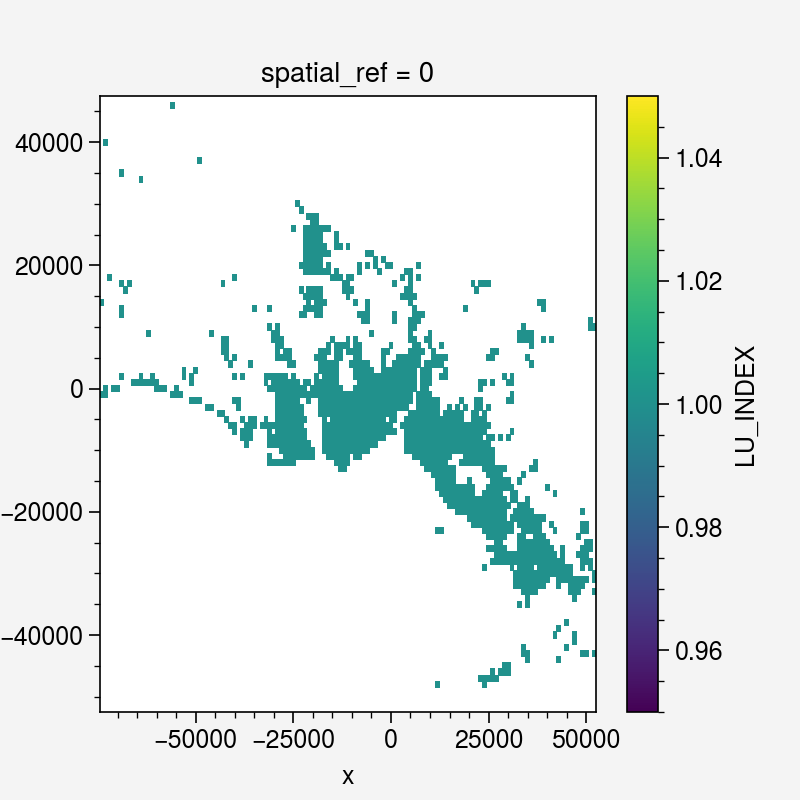

In [8]:
gg.plot()

In [9]:
gg = gg.rio.write_crs(proj_dt.rio.crs)
gdf = xr_vectorize(gg,
                   crs=gg.rio.crs,
                   mask=gg.values==1)

<AxesSubplot:>

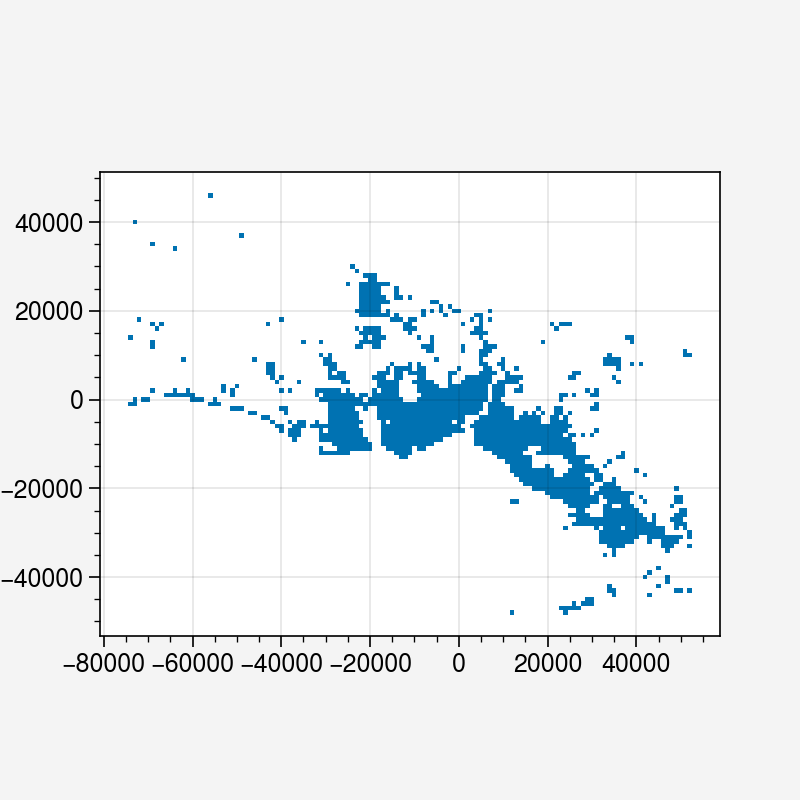

In [10]:
gdf.plot()

In [11]:
def clip_to_city(data, shapefile, crs_data, x_dims, y_dims):
    
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)

    data = data.rio.write_crs(crs_data)
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [12]:
x_dims = 'west_east'
y_dims = 'south_north'

## 3. Calculate IVT for urban borders

In [13]:
ivt_era5_urban_clip = clip_to_city(ivt_era5_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_era5_nourban_clip = clip_to_city(ivt_era5_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_urban_clip = clip_to_city(ivt_gfs_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_nourban_clip = clip_to_city(ivt_gfs_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

In [43]:
# era5 grid-based diff urban borders
ivt_era5_urban_minus_nourban = ivt_era5_urban_clip[variable] - ivt_era5_nourban_clip[variable] 

# gfs grid-based diff urban borders
ivt_gfs_urban_minus_nourban = ivt_gfs_urban_clip[variable] - ivt_gfs_nourban_clip[variable]

In [98]:
required_cols = ['time', 'XLONG', 'XLAT', variable]

In [318]:
pd_ivt_era5_urban_minus_nourban = ivt_era5_urban_minus_nourban.to_dataframe().dropna().reset_index()[required_cols]
pd_ivt_gfs_urban_minus_nourban = ivt_gfs_urban_minus_nourban.to_dataframe().dropna().reset_index()[required_cols]

In [319]:
# equate time dims for vis. purposes
pd_ivt_era5_urban_minus_nourban['time'] = pd_ivt_gfs_urban_minus_nourban['time']

In [321]:
repeating = len(pd_ivt_era5_urban_minus_nourban) / 6
time_numbers = np.repeat(np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']), repeating, axis=0).flatten()

pd_ivt_era5_urban_minus_nourban['time'] = time_numbers
pd_ivt_gfs_urban_minus_nourban['time'] = time_numbers

In [322]:
pd_ivt_gfs_urban_minus_nourban

,time,XLONG,XLAT,__xarray_dataarray_variable__
0,h1,29.115234,40.640182,-307.478149
1,h1,29.127106,40.640179,-311.964355
2,h1,29.257477,40.639915,-96.290771
3,h1,29.269318,40.639896,-65.068481
4,h1,29.115265,40.649178,-209.248291
...,...,...,...,...
13069,h6,28.097137,41.437489,-128.078369
13070,h6,28.288635,41.483749,235.371338
13071,h6,28.300659,41.483818,367.034058
13072,h6,28.288544,41.492744,182.699219


## 4. Create ERA5 and GFS Data

urban border spatial-average data

In [323]:
# era5
dict_prcp = {
    'era5_prcp_urban' : [ 5.204598 , 13.996422 , 25.822342 , 25.59414  , 12.011934 ,
        2.4620273],
    'era5_prcp_nourban' : [ 3.045293 ,  7.7670665, 20.095585 , 25.94906  , 18.076899 ,
        4.930991 ],
    'gfs_prcp_urban' : [ 0.8543113,  4.086869 , 17.88606  , 13.002373 ,  5.1822333,
        0.6454539],
    'gfs_prcp_nourban' : [ 0.67433757,  2.0679774 , 16.916418  , 11.410348  ,  2.732288  ,
        0.44267833]
}

pd_prcp = pd.DataFrame(dict_prcp)
pd_prcp['time'] = np.arange(1,7)
pd_prcp

,era5_prcp_urban,era5_prcp_nourban,gfs_prcp_urban,gfs_prcp_nourban,time
0,5.204598,3.045293,0.854311,0.674338,1
1,13.996422,7.767067,4.086869,2.067977,2
2,25.822342,20.095585,17.886060,16.916418,3
3,25.594140,25.949060,13.002373,11.410348,4
4,12.011934,18.076899,5.182233,2.732288,5
5,2.462027,4.930991,0.645454,0.442678,6


## 4. Visualization

### 4.1 Details to Plot

In [324]:
pd_ivt_gfs_urban_minus_nourban['forcing'] = 'gfs'
pd_ivt_era5_urban_minus_nourban['forcing'] = 'era5'

In [325]:
pd_ivt_gfs_urban_minus_nourban = pd_ivt_gfs_urban_minus_nourban.rename(columns={variable:'value'})
pd_ivt_era5_urban_minus_nourban = pd_ivt_era5_urban_minus_nourban.rename(columns={variable:'value'})

In [326]:
viol_gfs = pd_ivt_gfs_urban_minus_nourban.drop(columns=['XLONG', 'XLAT'])
viol_era5 = pd_ivt_era5_urban_minus_nourban.drop(columns=['XLONG', 'XLAT'])

In [327]:
viol = pd.concat([viol_gfs, viol_era5], axis=0).reset_index(drop=True)

In [ ]:
# not aynı şeyi precipitation urban-nourban için de yap

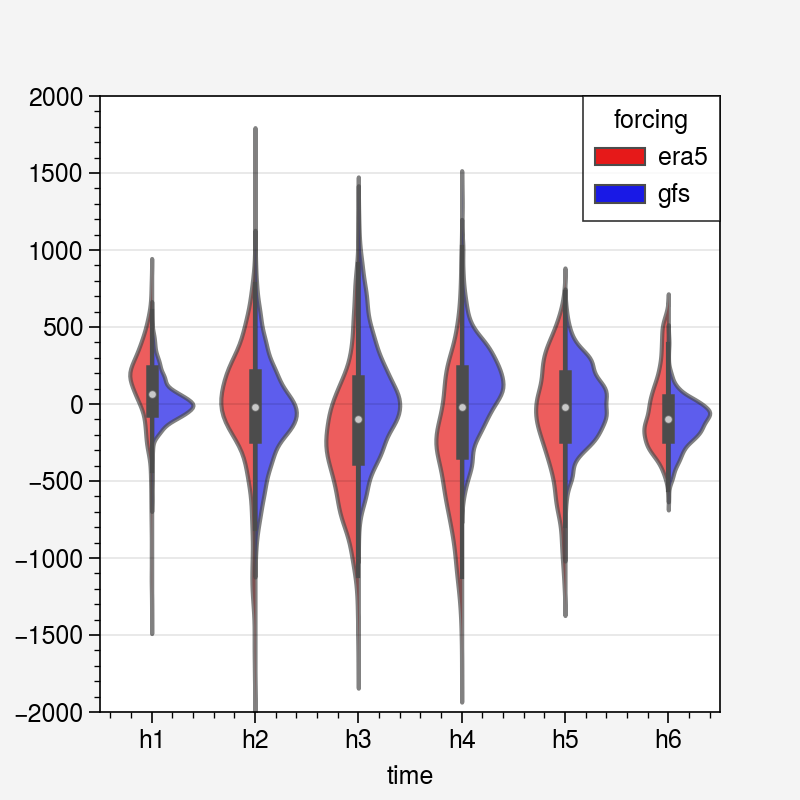

In [332]:
# violinplot
ax1=sns.violinplot(data=viol,
                   x='time',
                   y='value',
                   hue='forcing',
                   hue_order=['era5', 'gfs'],
                   palette=['red', 'blue'],
                   split=True,
                   showfliers = False,
                   color='red',
                   saturation=0.8,
                )
plt.setp(ax1.collections, alpha=.7)
ax1.set_ylim(-2000, 2000)
plt.show()

In [258]:
hh1

,time,value,source
0,1,-155.885193,era5
1,2,-154.232178,era5
2,3,-300.562317,era5
3,4,-278.543396,era5
4,5,-110.197815,era5
...,...,...,...
13069,2,51.276978,era5
13070,3,-15.788818,era5
13071,4,-9.315918,era5
13072,5,-62.104492,era5


In [230]:
pd_ivt_gfs_urban_minus_nourban[['time', variable]]

,time,__xarray_dataarray_variable__
0,2017-07-18 03:00:00,-307.478149
1,2017-07-18 03:00:00,-311.964355
2,2017-07-18 03:00:00,-96.290771
3,2017-07-18 03:00:00,-65.068481
4,2017-07-18 03:00:00,-209.248291
...,...,...
13069,2017-07-18 08:00:00,-128.078369
13070,2017-07-18 08:00:00,235.371338
13071,2017-07-18 08:00:00,367.034058
13072,2017-07-18 08:00:00,182.699219


In [223]:
pd_ivt_gfs_urban_minus_nourban

,time,XLONG,XLAT,__xarray_dataarray_variable__,source
0,2017-07-18 03:00:00,29.115234,40.640182,-307.478149,gfs
1,2017-07-18 03:00:00,29.127106,40.640179,-311.964355,gfs
2,2017-07-18 03:00:00,29.257477,40.639915,-96.290771,gfs
3,2017-07-18 03:00:00,29.269318,40.639896,-65.068481,gfs
4,2017-07-18 03:00:00,29.115265,40.649178,-209.248291,gfs
...,...,...,...,...,...
13069,2017-07-18 08:00:00,28.097137,41.437489,-128.078369,gfs
13070,2017-07-18 08:00:00,28.288635,41.483749,235.371338,gfs
13071,2017-07-18 08:00:00,28.300659,41.483818,367.034058,gfs
13072,2017-07-18 08:00:00,28.288544,41.492744,182.699219,gfs


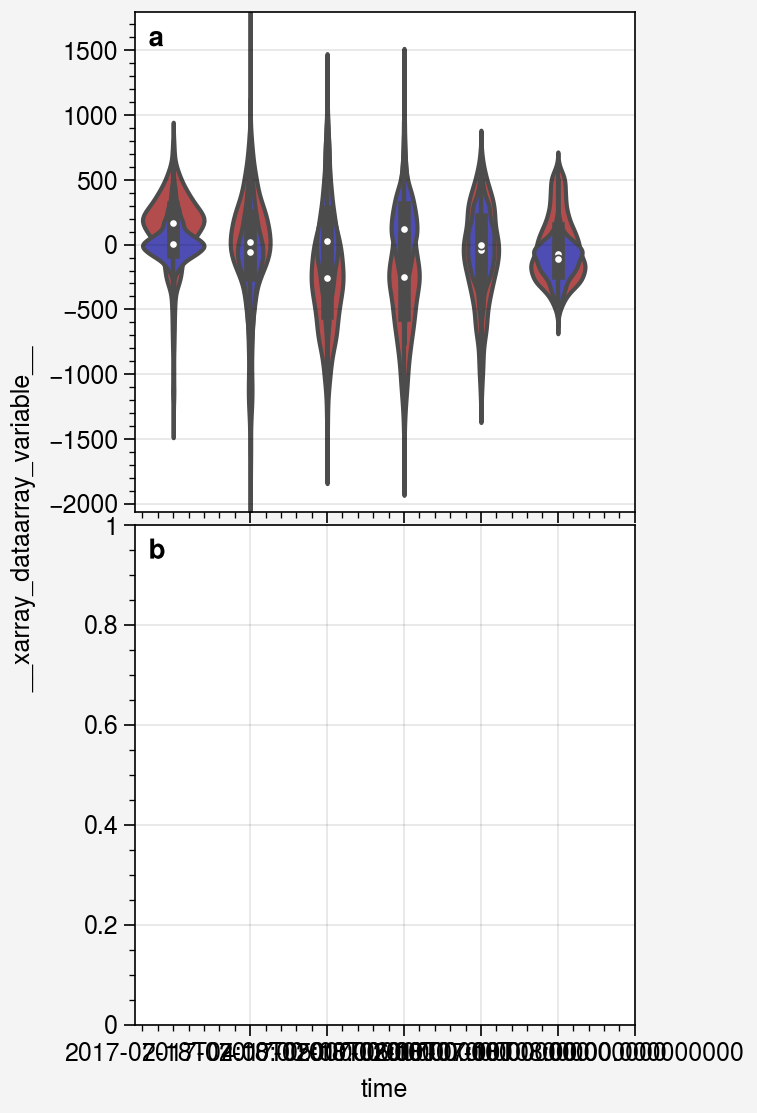

In [219]:
# fig features
fig_array = [[1], 
             [2],
            ]
graphic_no = 2


# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            proj=[None, None],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.5,
                            #share = 0,
                            sharex=3,
                           )

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

vio_era5 = sns.violinplot(data=pd_ivt_era5_urban_minus_nourban,
             x='time',
             y=variable,
             showfliers = False,
             color='red',
             saturation=0.4,
             ax=axs[0],
             alpha=0.4
              )

vio_gfs= sns.violinplot(data=pd_ivt_gfs_urban_minus_nourban,
             x='time',
             y=variable,
             showfliers = False,
             color='blue',
             saturation=0.4,
             ax=axs[0],
               alpha=0.4
                )
axs.set_xticks([])
axs.set_xticks(np.arange(1,7))

plt.show()

TypeError: violinplot() got an unexpected keyword argument 'hue'

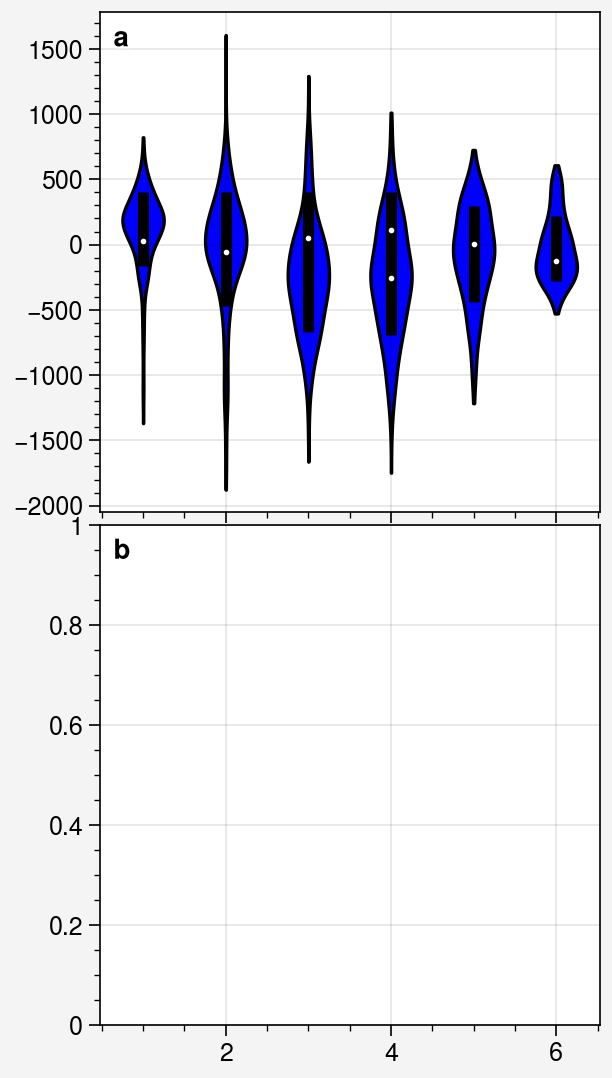

In [218]:
# fig features
fig_array = [[1], 
             [2],
            ]
graphic_no = 2


# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            proj=[None, None],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.5,
                            #share = 0,
                            sharex=3,
                           )

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

j = axs[0].violinplot(manage_violin_data(pd_ivt_era5_urban_minus_nourban),
                  lw=1.2, fillcolor='blue',
                  points=500, bw_method=0.3, means=True
              )
axs[0].violinplot(manage_violin_data(pd_ivt_gfs_urban_minus_nourban),
                  lw=1.2, fillcolor='red', hue='d',
                  points=500, bw_method=0.3, means=True
              )

In [209]:
def manage_violin_data(dt):
    
    extra = dt[['time', variable]].groupby('time').agg(pd.Series.tolist).transpose()
    
    managed = pd.DataFrame(data=None, index=range(len(extra.iloc[0,0])), columns=extra.columns)
    for i in range(6):
        managed.iloc[:,i] = extra.iloc[0,i]
        
    managed.columns=np.arange(1,7, dtype=int)
    return managed

In [205]:
manage_violin_data(pd_ivt_gfs_urban_minus_nourban)

time,2017-07-18 03:00:00,2017-07-18 04:00:00,2017-07-18 05:00:00,2017-07-18 06:00:00,2017-07-18 07:00:00,2017-07-18 08:00:00
0,-307.478149,568.760742,50.904831,-126.101868,-113.435577,-11.470947
1,-311.964355,647.276978,21.294556,-4.902344,-132.467041,-16.952209
2,-96.290771,230.677612,149.579590,229.036087,-25.464676,-38.389587
3,-65.068481,99.054596,185.837738,224.747589,-33.749786,-16.011139
4,-209.248291,586.241455,43.480728,-75.916946,-66.753372,-41.264526
...,...,...,...,...,...,...
2174,43.718018,52.340820,102.321289,180.678101,39.941772,-128.078369
2175,204.313965,218.228394,460.414917,41.792969,128.424805,235.371338
2176,257.565674,286.477661,461.013428,68.373047,116.869141,367.034058
2177,159.975830,242.984619,488.778320,63.004150,185.562256,182.699219


In [161]:
hh = pd_ivt_era5_urban_minus_nourban[['time', variable]].groupby('time').agg(pd.Series.tolist).transpose()

In [179]:
hh1 = pd.DataFrame(data=None, index=range(len(hh.iloc[0,0])), columns=hh.columns)
for i in range(6):
    hh1.iloc[:,i] = hh.iloc[0,i]

In [190]:
hh1.columns=np.arange(1,7, dtype=int)

In [191]:
hh1

,1,2,3,4,5,6
0,-155.885193,-81.544617,68.328552,157.443481,361.996704,-381.351196
1,-154.232178,-45.051025,119.335266,191.163269,372.789429,-385.431152
2,-300.562317,-151.415283,228.214783,240.658875,-58.031006,-115.194092
3,-278.543396,-135.169922,219.074585,95.002686,-118.323486,74.509644
4,-110.197815,-125.394226,-30.739502,260.075256,383.857361,-371.986572
...,...,...,...,...,...,...
2174,-305.803467,827.586304,342.000977,267.464233,274.763794,51.276978
2175,71.910889,512.847656,52.546387,225.087158,-170.667236,-15.788818
2176,114.551270,495.130127,-28.349854,142.557373,-190.298828,-9.315918
2177,71.543945,567.699585,32.058594,188.130859,-172.609619,-62.104492


In [188]:
axs[0].violinplot(
    data, lw=0.7, fillcolor='gray7',
    points=500, bw_method=0.3, means=True
)

(<a list of 5 PolyCollection objects>, <ErrorbarContainer object of 3 artists>)

In [187]:
data

xlabel,a,b,c,d,e
0,-0.613555,0.682797,0.922802,2.712688,0.332775
1,0.914384,0.266436,-1.576431,2.764987,-0.224940
2,0.502818,0.014872,0.858294,-2.078291,1.971858
3,0.353395,1.489007,3.775098,1.625966,-3.805613
4,0.569091,-1.256706,0.251128,1.796257,-1.186086
...,...,...,...,...,...
495,0.728050,1.285810,-0.659133,1.014121,3.038811
496,0.044665,-1.075686,1.459919,2.106872,5.065045
497,0.059118,-0.620517,-1.272589,-1.066364,-2.592830
498,-1.656022,-0.385707,-2.473468,-1.206205,0.350170


In [186]:
dataassign

NameError: name 'dataassign' is not defined

In [32]:
pd_ivt_gfs_urban_minus_nourban

,time,XLONG,XLAT,__xarray_dataarray_variable__
0,2017-07-18 03:00:00,29.115234,40.640182,-307.478149
1,2017-07-18 03:00:00,29.127106,40.640179,-311.964355
2,2017-07-18 03:00:00,29.257477,40.639915,-96.290771
3,2017-07-18 03:00:00,29.269318,40.639896,-65.068481
4,2017-07-18 03:00:00,29.115265,40.649178,-209.248291
...,...,...,...,...
13069,2017-07-18 08:00:00,28.097137,41.437489,-128.078369
13070,2017-07-18 08:00:00,28.288635,41.483749,235.371338
13071,2017-07-18 08:00:00,28.300659,41.483818,367.034058
13072,2017-07-18 08:00:00,28.288544,41.492744,182.699219


<AxesSubplot:xlabel='time', ylabel='__xarray_dataarray_variable__'>

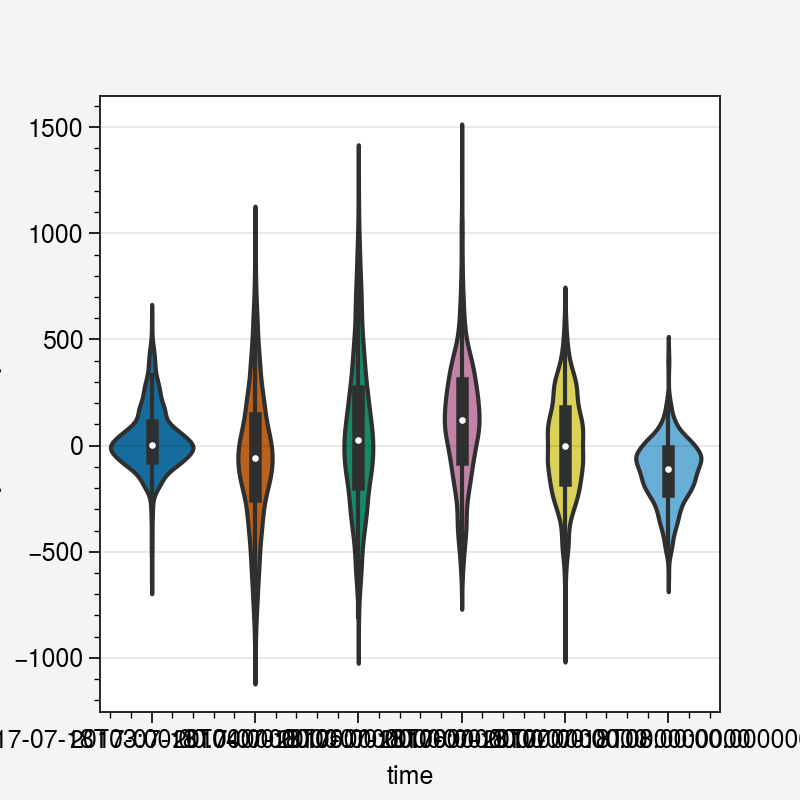

In [19]:
sns.violinplot(data=pd_ivt_gfs_urban_minus_nourban,
             x='time',
             y=variable,
             showfliers = False)

obj2 = axs[0].violinplot(
    hh1, lw=0.7, fillcolor='gray7',
    points=500, bw_method=0.3, means=True
)

## 5. Supporting Calculations

In [20]:
pd_ivt_era5_urban_minus_nourban['time'] = pd_ivt_era5_urban_minus_nourban['time'].astype('str')

In [23]:
#i = 0 # time indicator

for i in range(6):
    t = pd_ivt_era5_urban_minus_nourban['time'].unique()[i]
    d = pd_ivt_gfs_urban_minus_nourban['time'].unique()[i]

    print(fr"era5 median IVT diff. for {t}: ", pd_ivt_era5_urban_minus_nourban.query(fr'time=="{t}"')[variable].median())
    print(fr"gfs median IVT diff. for {d}: ", pd_ivt_gfs_urban_minus_nourban.query(fr'time=="{d}"')[variable].median())
    print('-------------')

era5 median IVT diff. for 2017-07-18 07:00:00:  166.1591796875
gfs median IVT diff. for 2017-07-18T03:00:00.000000000:  5.2904052734375
-------------
era5 median IVT diff. for 2017-07-18 08:00:00:  18.7177734375
gfs median IVT diff. for 2017-07-18T04:00:00.000000000:  -56.30389404296875
-------------
era5 median IVT diff. for 2017-07-18 09:00:00:  -254.257568359375
gfs median IVT diff. for 2017-07-18T05:00:00.000000000:  25.052734375
-------------
era5 median IVT diff. for 2017-07-18 10:00:00:  -249.0234375
gfs median IVT diff. for 2017-07-18T06:00:00.000000000:  120.479736328125
-------------
era5 median IVT diff. for 2017-07-18 11:00:00:  -44.13720703125
gfs median IVT diff. for 2017-07-18T07:00:00.000000000:  0.4587249755859375
-------------
era5 median IVT diff. for 2017-07-18 12:00:00:  -72.9521484375
gfs median IVT diff. for 2017-07-18T08:00:00.000000000:  -108.32595825195312
-------------
